In [14]:
# %load /Users/wayment/ipynb_defaults.py
%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import sys

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, average_precision_score

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_json('Dyna_1_example_outputs/relaxdb_esm3_seqstruct_layer22.json.zip')
d = pd.read_json('RelaxDB_with_other_metrics_22jan2025.json.zip')
d['entry_ID'] = [str(x) for x in d['entry_ID']]

df = df.merge(d, on='entry_ID')
df = df.loc[df.n_pos>=2] # removing 4 with 0 or 1 label for exchange

phos = ['MLC1PC','MLC1PN','27011','HMG1A','HMG1B','PCF11','ATS','FKBP','25636',
      'CIN1D1','CIN1D2','CDNFSP','CDNFCT','15255','16392','15795','17306','17783','DBD82','CHEA','CHEAYBD','7035','7036']


In [3]:
# Compare metrics with/without phosphate examples
print('AUROC')
print(df['AUROC'].mean())
print(df.loc[~df.entry_ID.isin(phos)]['AUROC'].mean())

print('norm. AUPRC')
print(df['AUPRC_norm'].mean())
print(df.loc[~df.entry_ID.isin(phos)]['AUPRC_norm'].mean())

AUROC
0.6066168879170541
0.6395184902598129
norm. AUPRC
0.12743829353953484
0.14667937521869157


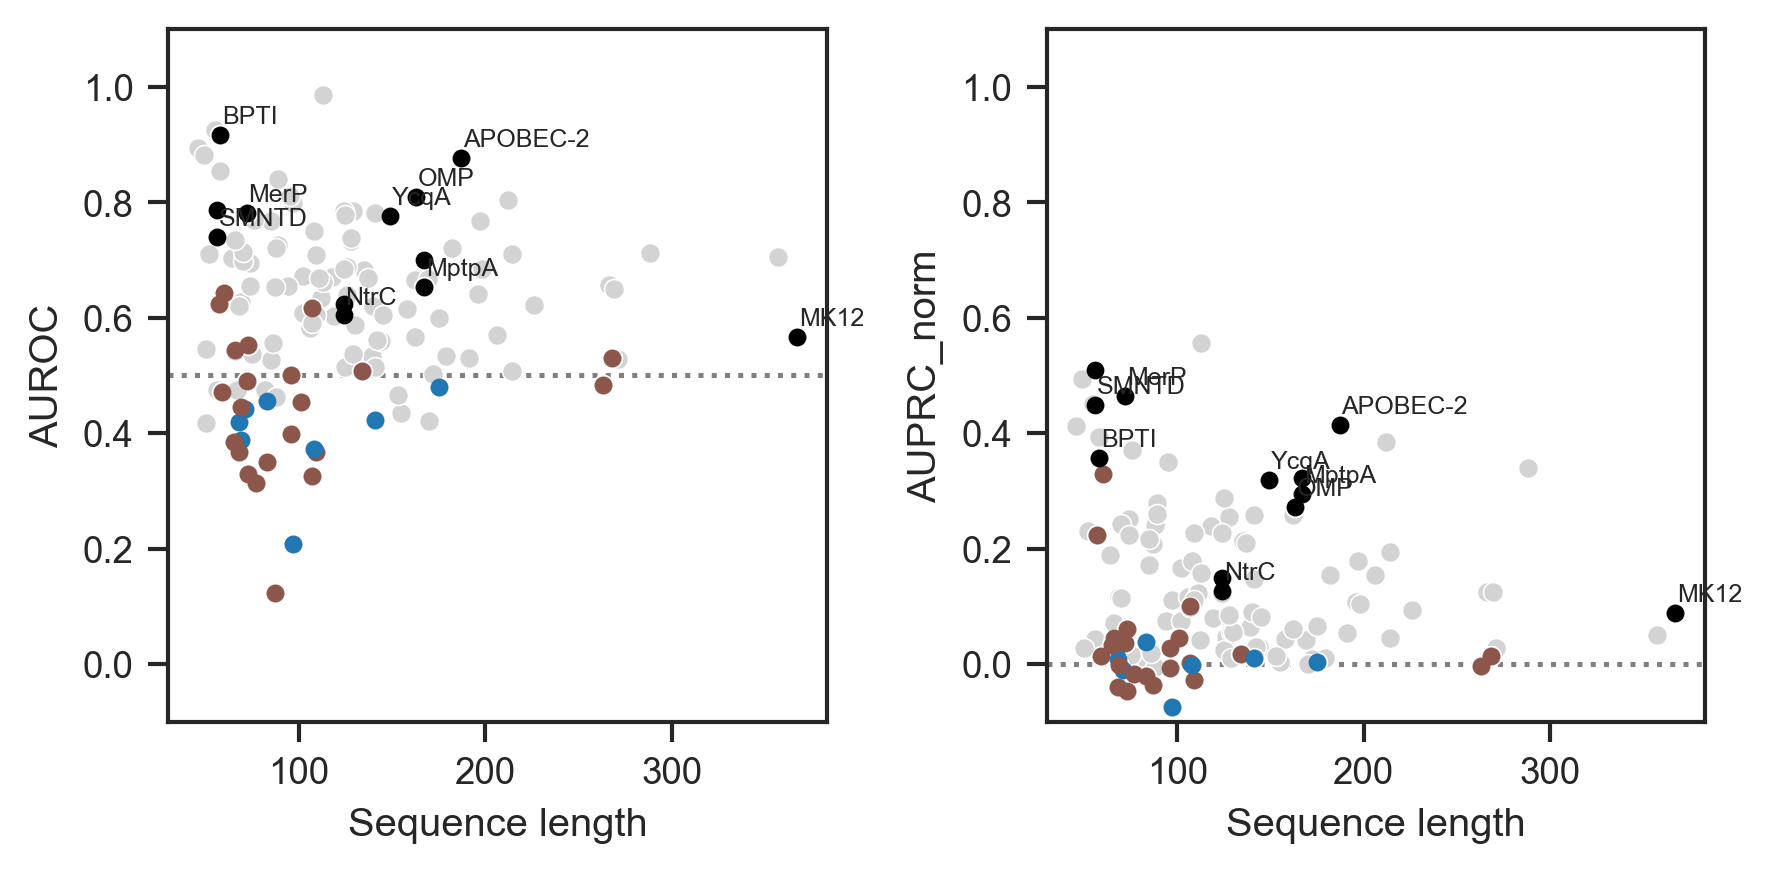

In [4]:
figure(figsize=(6,3))

hilight=['SMNTD','BPTI','MERP','25013','OMP','18306','26513','4762','MK12']
names=['SMNTD','BPTI','MerP','YcqA','OMP','APOBEC-2','MptpA','NtrC','MK12']

fast_motions=['15521','CDK3','17881','7056','50233','18380','CBFB','17246']

# updated case studies
updated = {'4762': {'AUROC': 0.6236,'AUPRC_norm': 0.1497},
'SMNTD': {'AUROC': .7871, 'AUPRC_norm': .5101},
'26513': {'AUROC': .7010, 'AUPRC_norm': .3229}}
    
for j,metric in enumerate(['AUROC','AUPRC_norm']):
    subplot(1,2,j+1)

    sns.scatterplot(x='seq length', y=metric,data=df,color='lightgrey')
    base=[0.5,0]

    for _, row in df.iterrows():

        if row['entry_ID'] in hilight:
            
            scatter(row['seq length'], row[metric],color='black',s=12)
            text(row['seq length']+1, row[metric]+0.02,names[hilight.index(row['entry_ID'])],fontsize=6)

        elif row['entry_ID'] in phos:
            scatter(row['seq length'], row[metric],color='tab:brown',s=12)
            #text(row['seq length']+1, row[metric]+0.01,row['entry_ID'],fontsize=4)

        if row['entry_ID'] in fast_motions:
            scatter(row['seq length'], row[metric],color='tab:blue',s=12)
            
    # updated case studies
    for k in ['4762','SMNTD','26513']:
        x = df.loc[df.entry_ID==k]['seq length'].iloc[0]
        scatter(x, updated[k][metric],color='black',s=12)

        # else:
        #     text(row['seq length'], row['AUROC'],row['entry_ID'],fontsize=3)

    axhline(base[j],zorder=0,color='grey',linestyle=':')
    xlabel('Sequence length')
    ylabel(metric)

    ylim([-0.1,1.1])

tight_layout()


In [5]:
fast_motions=['15521','CDK3','17881','7056','50233','18380','CBFB','17246']

for x in fast_motions:
    print(x, "%.2f" % df.loc[df.entry_ID==x]['AUROC'].iloc[0])

15521 0.42
CDK3 0.39
17881 0.44
7056 0.46
50233 0.37
18380 0.21
CBFB 0.42
17246 0.48


In [6]:
m=[]

def get_cons_bin(cons):
    if pd.isna(cons):
        return NaN
    else:
        return np.digitize(cons, np.array([.33,.67]))

for _, row in df.loc[~df.entry_ID.isin(phos)].iterrows():
        for i in range(len(row['sequence'])):

            dssp_dct={'C': 'Loop','E':'Sheet','H':'Helix', ' ': 'Loop'}

            m.append({'AA': row['sequence'][i],
                      'seqpos': i,
                      'label': row['label'][i],
                      'p': row['p'][i],
                      'entry_ID': row['entry_ID'],
                      'Classification': row['Classification'],
                      'DSSP': dssp_dct[row['DSSP'][i]],
                      'R2_R1': row['R2_R1'][i],
                      'dR2': row['dR2'][i],
                      'cons': row['cons_BLOSUM62'][i],
                      'cons_bin': get_cons_bin(row['cons_BLOSUM62'][i]),
                      'coverage': row['coverage'][i],
                    'pLDDT': row['pLDDT'][i],
                      'SASA': row['SASA'][i],
                      'eval_mask': row['eval_mask'][i],
                      'target': row['target'][i],
                      'NOE': row['NOE'][i],})

melt = pd.DataFrame.from_records(m)

In [7]:
melt.keys()

Index(['AA', 'seqpos', 'label', 'p', 'entry_ID', 'Classification', 'DSSP',
       'R2_R1', 'dR2', 'cons', 'cons_bin', 'coverage', 'pLDDT', 'SASA',
       'eval_mask', 'target', 'NOE'],
      dtype='object')

In [12]:
res.keys()

Index([], dtype='object')

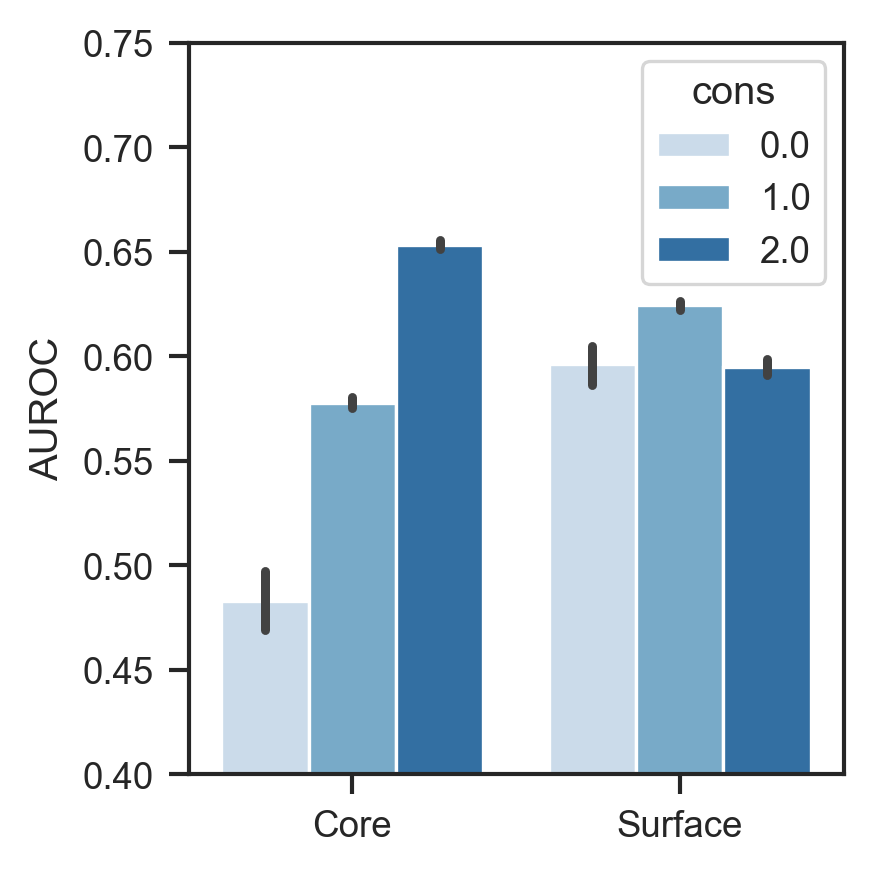

In [21]:
def calc_auroc(d,plot_curve=False):
    mask = d['eval_mask'].values
    target = np.clip(d['target'].values,0,1)
    prob = d['p'].values
    
    auroc = roc_auc_score(target, prob, sample_weight = mask)
    auprc = average_precision_score(target, prob, sample_weight = mask)
    
    t = target[np.where(mask==1)]
    baseline = np.sum(t) / np.sum(mask)
    return auroc, auprc, auprc-baseline

labels=['buried','exposed']
res=[]
for s in melt.SASA.unique():
    for c in sorted(melt.cons_bin.unique()):
        tmp = melt.loc[melt.cons_bin==c][melt.SASA==s]
        for bs in range(200):
            try:
                tmp_bs = tmp.sample(frac=1.0,replace=True,random_state=bs)
                auroc, auprc, auprc_norm = calc_auroc(tmp_bs)
                res.append({'cons': c, 'AUROC': auroc, 'sasa':s, 'auprc': auprc, 'auprc_norm':auprc_norm,'bs': bs})
            except: # this is to bypass if a random sample has no positive labels.
                pass
            if len(res)==100:
                break

res = pd.DataFrame.from_records(res)

figure(figsize=(3,3))
sns.barplot(y='AUROC',hue='cons',x='sasa',data=res, palette='Blues')
ylim([0.4,0.75])
xticks([0,1],['Core','Surface'])
xlabel('')
ylabel('AUROC')
tight_layout()

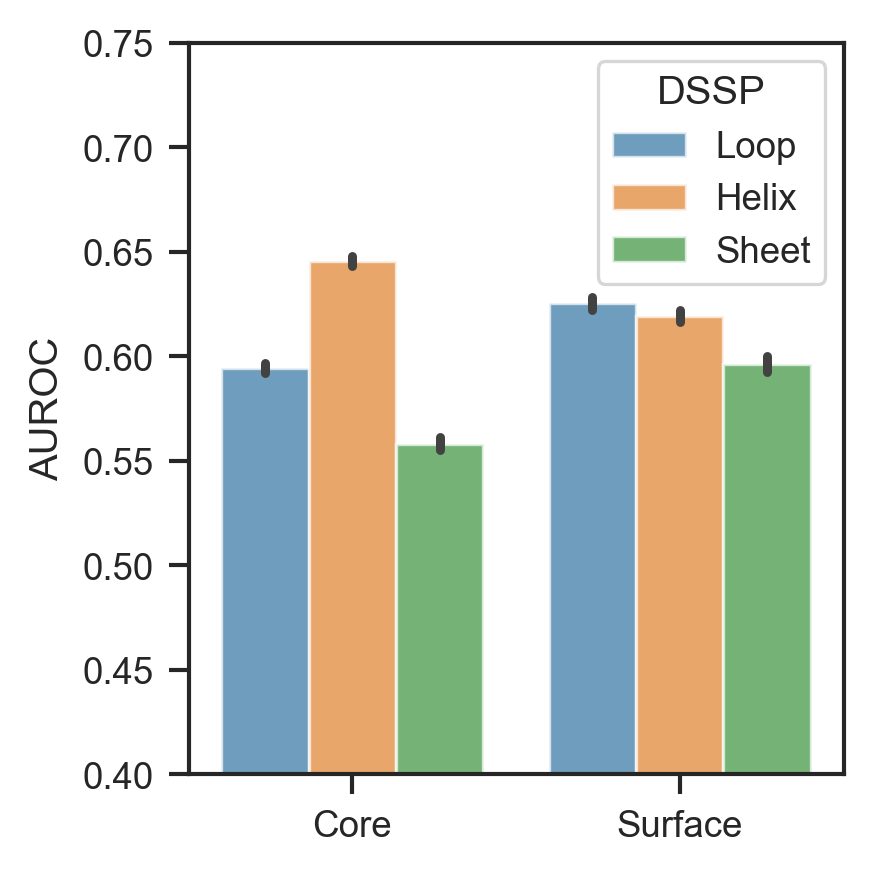

In [19]:
labels=['buried','exposed']
res=[]
for s in melt.SASA.unique():
    for d in melt.DSSP.unique():
        tmp = melt.loc[melt.DSSP==d][melt.SASA==s]
        for bs in range(200):
            try:
                tmp_bs = tmp.sample(frac=1.0,replace=True,random_state=bs)
                auroc, auprc, auprc_norm = calc_auroc(tmp_bs)
                res.append({'DSSP': d, 'AUROC': auroc, 'sasa':s, 'auprc': auprc, 'auprc_norm':auprc_norm,'bs': bs})
            except:
                pass
            if len(res)==100:
                break

res = pd.DataFrame.from_records(res)

figure(figsize=(3,3))
sns.barplot(y='AUROC',hue='DSSP',x='sasa',data=res,alpha=0.7)
ylim([0.4,0.75])
xticks([0,1],['Core','Surface'])
xlabel('')
ylabel('AUROC')
tight_layout()

In [22]:
#Calculations for updating revisited examples

entry_ID='4762'
p_missing = df.loc[df.entry_ID==entry_ID]['p'].iloc[0]

orig_label = df.loc[df.entry_ID==entry_ID]['label'].iloc[0]
orig_target = df.loc[df.entry_ID==entry_ID]['target'].iloc[0]
orig_mask = df.loc[df.entry_ID==entry_ID]['eval_mask'].iloc[0]

new_target = copy(orig_target)
new_mask = copy(orig_mask)
new_label = list(orig_label)

for x in [56,97]: #exchange-broadened
    new_label[x-1] = '.'
    new_mask[x-1] = 1
    new_target[x-1] = 1
    
for x in [60,61,62,66,101]:
    new_label[x-1] = '^'
    new_mask[x-1] = 1
    new_target[x-1] = 1
    
new_label=''.join(new_label)
print(orig_label)
print(new_label)

from torcheval.metrics.functional import binary_auroc, binary_auprc
import torch

# Copied from Dyna-1 utils.py
def get_masked(logits, labels, mask):
    """Mask logits and labels using a given mask"""
    if isinstance(mask, np.ndarray):
        masked_logits = logits[mask.astype(bool)]
        masked_labels = labels[mask.astype(bool)]
    else:
        masked_logits = logits[mask.bool()].view(-1)
        masked_labels = labels[mask.bool()].view(-1)

    return masked_logits, masked_labels

def get_auroc(masked_logits, masked_labels):
    """Evaluate AUROC, AUPRC, and norm AUPRC for given logits, labels"""

    if isinstance(masked_labels, np.ndarray):
        masked_labels = torch.tensor(masked_labels)
    if isinstance(masked_logits, np.ndarray):
        masked_logits = torch.tensor(masked_logits)
    
    roc = binary_auroc(masked_logits, masked_labels)
    prc = binary_auprc(masked_logits, masked_labels)
    
    baseline = masked_labels.sum()/len(masked_labels)
    
    return abs(roc), abs(prc), abs(prc)-baseline

print('NtrC (4762)')
print('Orig metrics')
old_auroc, _, old_nauprc = get_auroc(*get_masked(np.array(p_missing), np.array(orig_target), np.array(orig_mask)))

print('Updated metrics')
new_auroc, _, new_nauprc = get_auroc(*get_masked(np.array(p_missing), np.array(new_target), np.array(new_mask)))

print(old_auroc, new_auroc)
print(old_nauprc, new_nauprc)

..vvAAAAAAAAAAAAAAAA^AAAAAAAAAAAAA^^AAAAAAAAAAApAAAAAA.x.pAxxxA^^x.AAAAAApAApx^xA^A.^AA^AA^^...xx^bAx^p.pAAAAAxAAAAAAAAAAvvv
..vvAAAAAAAAAAAAAAAA^AAAAAAAAAAAAA^^AAAAAAAAAAApAAAAAA...pA^^^A^^^.AAAAAApAApx^xA^A.^AA^AA^^...x.^bA^^p.pAAAAAxAAAAAAAAAAvvv
NtrC (4762)
Orig metrics
Updated metrics
tensor(0.6041, dtype=torch.float64) tensor(0.6236, dtype=torch.float64)
tensor(0.1266, dtype=torch.float64) tensor(0.1497, dtype=torch.float64)


In [24]:
#sanity check original is the same as was in data
print(df.loc[df.entry_ID=='4762'][['AUROC','AUPRC_norm']])

      AUROC  AUPRC_norm
3  0.604053    0.126574


In [25]:
entry_ID='SMNTD'
p_missing = df.loc[df.entry_ID==entry_ID]['p'].iloc[0]
orig_label = df.loc[df.entry_ID==entry_ID]['label'].iloc[0]
orig_target = df.loc[df.entry_ID==entry_ID]['target'].iloc[0]
orig_mask = df.loc[df.entry_ID==entry_ID]['eval_mask'].iloc[0]

new_target = copy(orig_target)
new_mask = copy(orig_mask)
new_label = list(orig_label)

for x in [13,39]: #exchange-broadened
    new_label[x-1] = '.'
    new_mask[x-1] = 1
    new_target[x-1] = 1
    
new_label=''.join(new_label)
print(orig_label)
print(new_label)

print('SMNTD')
print('Orig metrics')
old_auroc, _, old_nauprc = get_auroc(*get_masked(np.array(p_missing), np.array(orig_target), np.array(orig_mask)))

print('Updated metrics')
new_auroc, _, new_nauprc = get_auroc(*get_masked(np.array(p_missing), np.array(new_target), np.array(new_mask)))

print(old_auroc, new_auroc)
print(old_nauprc, new_nauprc)

vAAAAAAAAAA^xAAAAApAAAA^AA^^AA^AAAAA^.x^AAAAAA^AAAAApvtt
vAAAAAAAAAA^.AAAAApAAAA^AA^^AA^AAAAA^..^AAAAAA^AAAAApvtt
SMNTD
Orig metrics
Updated metrics
tensor(0.7398, dtype=torch.float64) tensor(0.7871, dtype=torch.float64)
tensor(0.4487, dtype=torch.float64) tensor(0.5101, dtype=torch.float64)


In [26]:
entry_ID='26513'
p_missing = df.loc[df.entry_ID==entry_ID]['p'].iloc[0]
orig_label = df.loc[df.entry_ID==entry_ID]['label'].iloc[0]
orig_target = df.loc[df.entry_ID==entry_ID]['target'].iloc[0]
orig_mask = df.loc[df.entry_ID==entry_ID]['eval_mask'].iloc[0]

new_target = copy(orig_target)
new_mask = copy(orig_mask)
new_label = list(orig_label)

for x in [15,19,20,22]: #exchange-broadened in P loop
    new_label[x-1] = '.'
    new_mask[x-1] = 1
    new_target[x-1] = 1
    
new_label=''.join(new_label)
print(orig_label)
print(new_label)

print('Mptpa')
print('Orig metrics')
old_auroc, _, old_nauprc = get_auroc(*get_masked(np.array(p_missing), np.array(orig_target), np.array(orig_mask)))

print('Updated metrics')
new_auroc, _, new_nauprc = get_auroc(*get_masked(np.array(p_missing), np.array(new_target), np.array(new_mask)))

print(old_auroc, new_auroc)
print(old_nauprc, new_nauprc)

...vvvvpvAAAAAx..Axx.xpAAAAAxAAAxAAAAAAAAAAAAAA^AAAAAAAAAxAAAAx^AAAxA^ApAxxAAA^AAAAAAAAxAAAAAxAAxAAAAAAAAAAAAAAAAAAAAxpAxv.vvvAvAApAAAA.AAAAAAAAAAAA^ApAAAAxxAAAxAvvvpv
...vvvvpvAAAAA...A....pAAAAAxAAAxAAAAAAAAAAAAAA^AAAAAAAAAxAAAAx^AAAxA^ApAxxAAA^AAAAAAAAxAAAAAxAAxAAAAAAAAAAAAAAAAAAAAxpAxv.vvvAvAApAAAA.AAAAAAAAAAAA^ApAAAAxxAAAxAvvvpv
Mptpa
Orig metrics
Updated metrics
tensor(0.6531, dtype=torch.float64) tensor(0.7310, dtype=torch.float64)
tensor(0.2952, dtype=torch.float64) tensor(0.3229, dtype=torch.float64)
